In [5]:
! pip install -q kaggle

! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

! unzip -q skin-cancer-mnist-ham10000.zip

100% 5.20G/5.20G [00:33<00:00, 156MB/s]
100% 5.20G/5.20G [00:33<00:00, 165MB/s]


In [6]:
# # Remove the downloaded zip file after extraction (Optional)
# ! rm skin-cancer-mnist-ham10000.zip

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
import itertools
import seaborn as sns
import tensorflow as tf
import keras

from glob import glob
from PIL import Image as pil_image
from IPython.display import Image as Image
from matplotlib.pyplot import imshow, imsave

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(123)
plt.rcParams['figure.figsize'] = (10, 8)

In [19]:
plt.rcParams['figure.figsize'] = (10, 8)

In [8]:
main_df = pd.read_csv('HAM10000_metadata.csv')
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


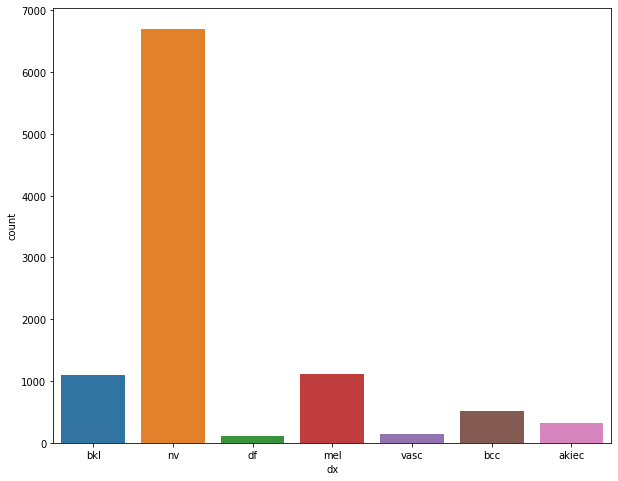

In [20]:
sns.countplot(x='dx', data=main_df)

In [21]:
main_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

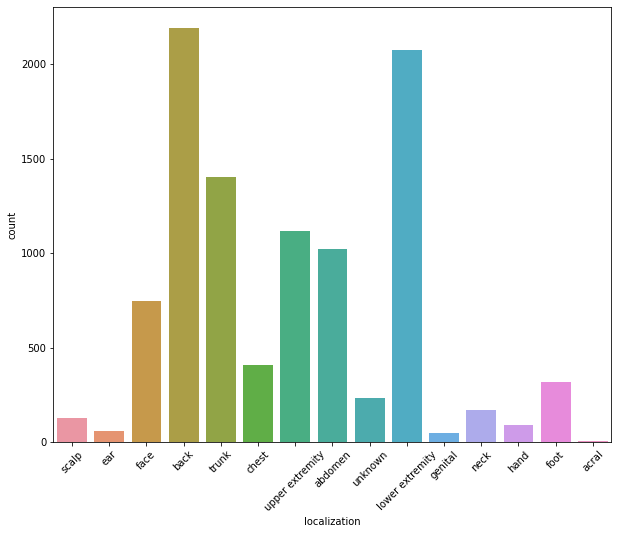

In [22]:
sns.countplot(x='localization', data=main_df)
plt.xticks(rotation=45)

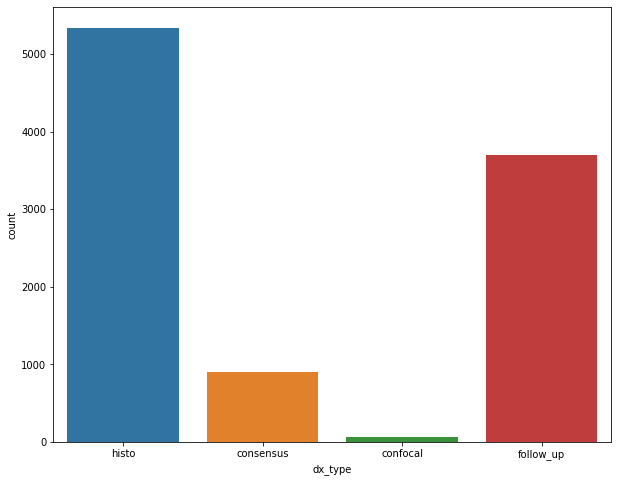

In [23]:
sns.countplot(x='dx_type', data=main_df)

In [24]:
main_df['dx_type'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [25]:
main_df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [26]:
print(main_df['age'].mean())
print(main_df['age'].median())
main_df['age'].fillna(main_df['age'].mean(), inplace=True)

51.863828077927295
50.0


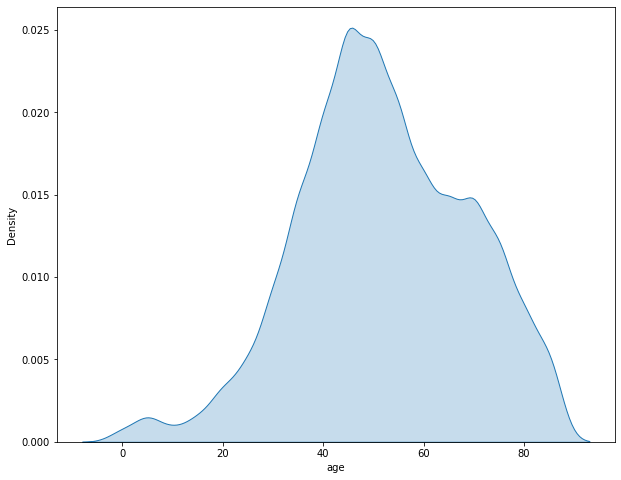

In [27]:
sns.kdeplot(main_df['age'], shade=True)

In [28]:
main_df['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [29]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_classes_dict = {
    0:'nv',
    1:'mel',
    2:'bkl',
    3:'bcc',
    4:'akiec',
    5:'vasc',
    6:'df'
}

main_df['cell_type'] = main_df['dx'].map(lesion_type_dict)

In [30]:
main_df['cell_type_idx'] = pd.Categorical(main_df['cell_type']).codes

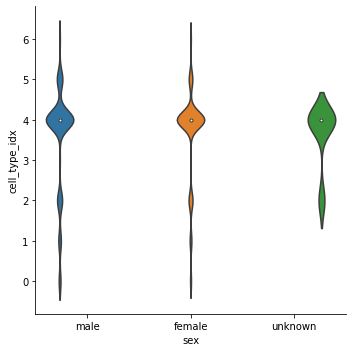

In [31]:
sns.catplot(x="sex", 
            y="cell_type_idx",
            hue="sex",
            data=main_df,
            kind="violin")

In [32]:
#pil_image = os.path.join('images')
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('', '*', '*.jpg'))}

In [33]:
main_df['path'] = main_df['image_id'].map(image_path.get)
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,ham10000_images_part_2/ISIC_0031633.jpg


In [34]:
image_example = np.asarray(pil_image.open(main_df['path'][0]))

In [35]:
image_example.shape

(450, 600, 3)

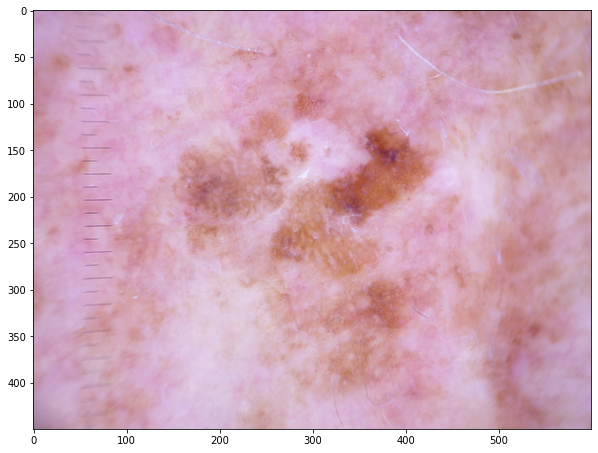

In [36]:
plt.imshow(image_example)

In [37]:
main_df['image'] = main_df['path'].map(lambda x: np.asarray(pil_image.open(x).resize((120,90))))

In [38]:
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0027419.jpg,"[[[190, 152, 194], [192, 155, 197], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0025030.jpg,"[[[24, 13, 22], [24, 14, 23], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0026769.jpg,"[[[185, 126, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0025661.jpg,"[[[24, 11, 17], [25, 11, 20], [31, 16, 27], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,ham10000_images_part_2/ISIC_0031633.jpg,"[[[131, 89, 111], [143, 98, 121], [153, 108, 1..."


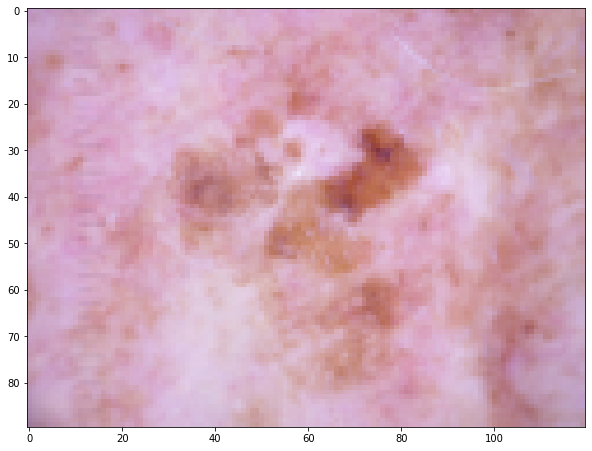

In [39]:
plt.imshow(main_df['image'][0])

In [40]:
main_df['image'][0].shape

(90, 120, 3)

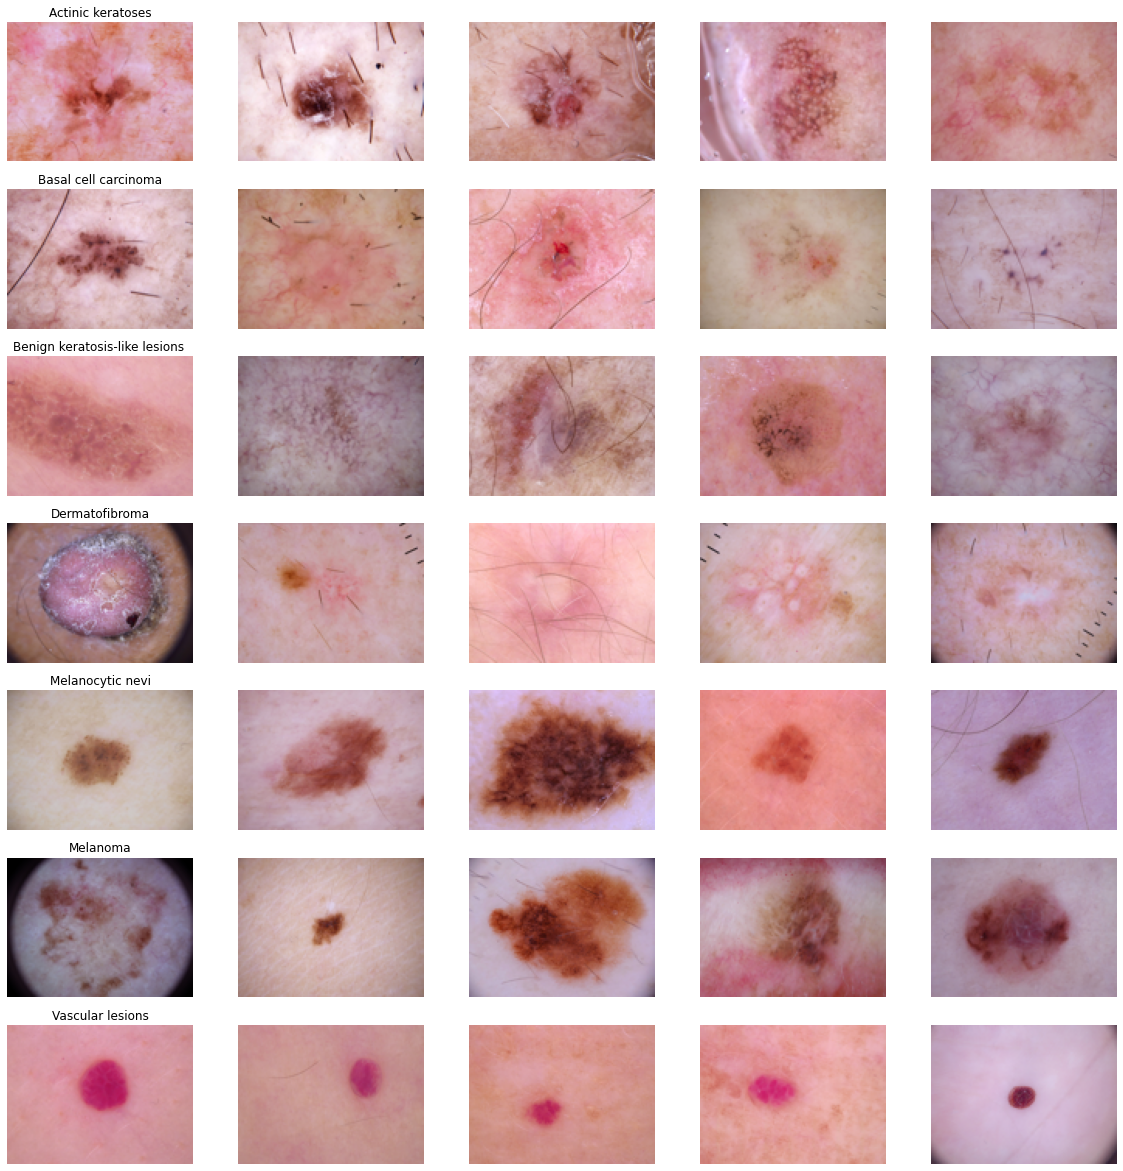

In [41]:
fig,axes = plt.subplots(7,5,figsize=(20,21))
for nth_axis,(cell_type_name, cell_type_row) in zip(axes, main_df.sort_values(['cell_type']).groupby('cell_type')):
    nth_axis[0].set_title(cell_type_name)
    for column_axis,(_, column_row) in zip(nth_axis, cell_type_row.sample(5).iterrows()):
        column_axis.imshow(column_row['image'])  
        column_axis.axis('off')

In [42]:
features = main_df.drop(['cell_type_idx'],axis=1)

target = main_df['cell_type_idx']

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features, target, test_size=0.01)

In [43]:
x_train = np.asarray(X_TRAIN['image'].tolist())
x_test = np.asarray(X_TEST['image'].tolist())

In [44]:
print(x_train.shape)
print(x_test.shape)

(9914, 90, 120, 3)
(101, 90, 120, 3)


In [45]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train-x_train_mean) / x_train_std
x_test = (x_test-x_test_mean) / x_test_std

In [46]:
print(Y_TRAIN.shape)
print(Y_TEST.shape)

(9914,)
(101,)


In [47]:
y_train = to_categorical(Y_TRAIN, num_classes=7)
y_test = to_categorical(Y_TEST, num_classes=7)

In [48]:
print(y_train.shape)
print(y_test.shape)

(9914, 7)
(101, 7)


In [49]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.15)

In [50]:
X_train  = X_train.reshape(X_train.shape[0], 90, 120, 3)
x_test  = x_test.reshape(x_test.shape[0], 90, 120, 3)
X_val  = X_val.reshape(X_val.shape[0], 90, 120, 3)

In [51]:
print(X_train.shape)
print(x_test.shape)
print(X_val.shape)

(8426, 90, 120, 3)
(101, 90, 120, 3)
(1488, 90, 120, 3)


In [52]:
input_shape = (90, 120, 3)
num_classes = 7

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same', input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu', padding='Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='Same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 120, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 120, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 60, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 60, 64)        36928     
                                                        

In [53]:
# Compile the model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [54]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.0001, 
                                            min_lr=0.000001)

In [55]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1 # Randomly zoom image 
)


# Fit the model
epochs = 30
batch_size = 16
model.fit(datagen.flow(X_train, 
                       Y_train, 
                       batch_size=batch_size), 
          epochs = epochs, 
          validation_data = (X_val,Y_val),
          verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, 
          callbacks=[learning_rate_reduction])

Epoch 1/30
526/526 [==============================] - 44s 62ms/step - loss: 1.0270 - accuracy: 0.6615 - val_loss: 0.8335 - val_accuracy: 0.6909 - lr: 0.0010
Epoch 2/30
526/526 [==============================] - 33s 62ms/step - loss: 0.9040 - accuracy: 0.6768 - val_loss: 0.9260 - val_accuracy: 0.6902 - lr: 0.0010
Epoch 3/30
526/526 [==============================] - 33s 62ms/step - loss: 0.8663 - accuracy: 0.6819 - val_loss: 0.7887 - val_accuracy: 0.7117 - lr: 0.0010
Epoch 4/30
526/526 [==============================] - 32s 61ms/step - loss: 0.8392 - accuracy: 0.6950 - val_loss: 0.8039 - val_accuracy: 0.7137 - lr: 0.0010
Epoch 5/30
526/526 [==============================] - 31s 59ms/step - loss: 0.8004 - accuracy: 0.7088 - val_loss: 0.7314 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 6/30
526/526 [==============================] - 31s 59ms/step - loss: 0.7847 - accuracy: 0.7216 - val_loss: 0.7442 - val_accuracy: 0.7245 - lr: 0.0010
Epoch 7/30
526/526 [==============================] - 32s 

In [56]:
model.save('models/model_SC.h5')

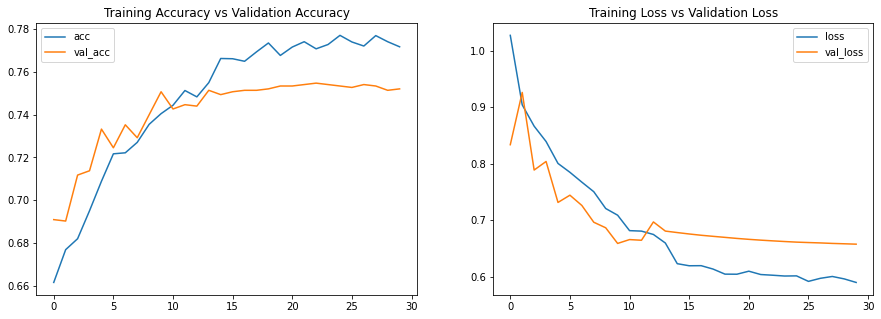

In [57]:
def plot_(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="acc")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

In [58]:
print("MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is : ", round(max(model.history.history['val_accuracy'])*100,4))

MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is :  75.4704
